# Following p110, proving the issue with 'naive method'

In [52]:
cap = 27500
pp = 533
weeks = 52
contribution = 520
super_tax = 0.85
pp / 2 * weeks + contribution / 2 * super_tax * weeks

25350.0

In [1]:
import matplotlib.pyplot as plt 
import numpy as np



In [50]:
# Initialize constants
B = 1000  # Number of iterations
n = 100  # Sample size
p = 100  # Number of features

mean = 0
sd = 1

In [46]:
from sklearn.linear_model import LassoCV
import statsmodels.api as sm

def lasso(X,y): 
    """fit cv lasso and return coefficients"""
    X = X - np.mean(X, axis=0)
    y = y - np.mean(y)
    reg = LassoCV(cv=5, random_state=0).fit(X, y[:,0])
    ypred = reg.predict(X)
    return reg.coef_, y[:,0] - ypred
def double_lasso(Y,X,D,i):
    """Partial out, using lasso, the X"""
    fitY, resY = lasso(X, Y)
    fitD, resD= lasso(X, D)
    Orthogonal[i] = sm.OLS(resY, sm.add_constant(resD)).fit().params[1]

def generate_data():
    gamma = (1 / (np.arange(1, p + 1) ** 2)).reshape(p, 1)
    beta = (1 / (np.arange(1, p + 1) ** 2)).reshape(p, 1)
    X = np.random.normal(mean, sd, n * p).reshape(n, p)
    D = (X @ gamma) + np.random.normal(mean, sd, n).reshape(n, 1) / 4
    Y = D + (X @ beta) + np.random.normal(mean, sd, n).reshape(n, 1)
    return Y,X,D


def naive_selection(Y,X,D,i):
    """First use lasso Y ~ (D,X) to select features. Then OLS on Y~(D, selected(X)). This is a bad method
        AKA post-lasso? 
    """
    # Single selection method using rlasso
    coefficients, _ = lasso(np.concatenate((D, X), axis=1), Y)
    coefficients = coefficients[2:] # first two coeff are intercept and treatment
    SX_IDs = np.where(coefficients != 0)[0]

    # Check if any X coefficients are selected
    if sum(SX_IDs) == 0:
        # If no X coefficients are selected, regress Y on D only
        Naive[i] = sm.OLS(Y, sm.add_constant(D)).fit().params[1]
    else:
        # If X coefficients are selected, regress Y on selected X and D
        X_D = np.concatenate((D, X[:, SX_IDs]), axis=1)
        Naive[i] = sm.OLS(Y, sm.add_constant(X_D)).fit().params[1]


def double_lasso(Y,X,D,i):
    """Partial out, using lasso, the X"""
    fitY, resY = lasso(X, Y)
    fitD, resD= lasso(X, D)
    Orthogonal[i] = sm.OLS(resY, sm.add_constant(resD)).fit().params[1]

In [51]:
%%capture
Naive = np.zeros(B)
Orthogonal = np.zeros(B)

# Iterate through B simulations
for i in range(B):
    if i % 20 == 0:
        print(i)
    Y,X,D = generate_data()
    naive_selection(Y,X,D,i)
    double_lasso(Y,X,D,i)


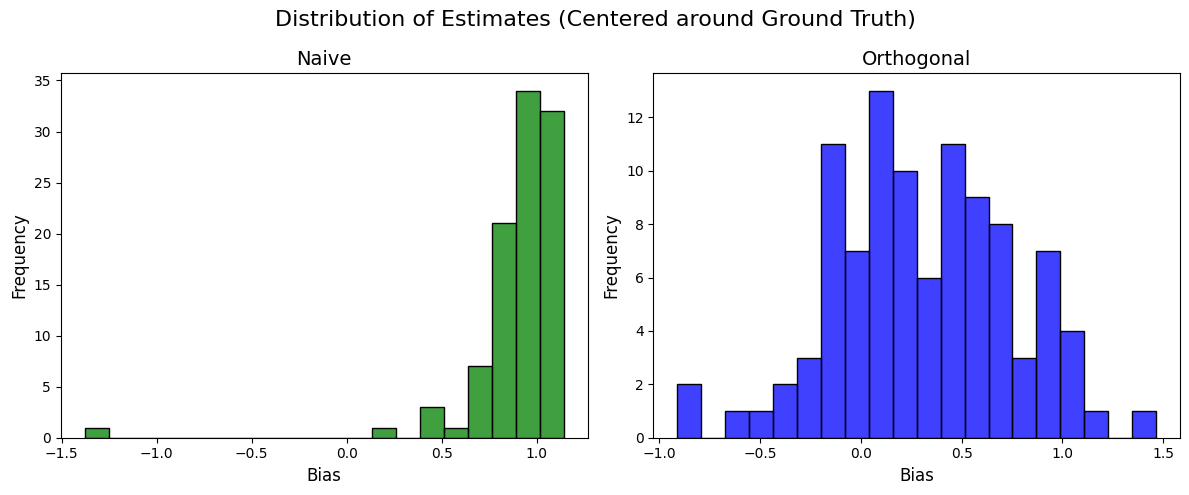

In [49]:
import seaborn as sns

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot a histogram for the 'Naive' estimates vector
sns.histplot(Naive-1, bins=20, kde=False, color='green', ax=axes[0])
axes[1].set_title('Orthogonal', fontsize=14)
axes[1].set_xlabel('Bias', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)

# Plot a histogram for the 'Orthogonal' estimates vector
sns.histplot(Orthogonal-1, bins=20, kde=False, color='blue', ax=axes[1])
axes[0].set_title('Naive', fontsize=14)
axes[0].set_xlabel('Bias', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)

# Add a title to the entire figure
fig.suptitle('Distribution of Estimates (Centered around Ground Truth)', fontsize=16)

# Display the histograms side by side
plt.tight_layout()
plt.show()